In [1]:
!pip install pickle4

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pickle4: filename=pickle4-0.0.1-py2.py3-none-any.whl size=19708 sha256=4a017ea23b16a69e4a330aee9db0660893cb983ec175a973ff60cea79b043aed
  Stored in directory: c:\users\perry\appdata\local\pip\cache\wheels\fa\2c\86\ea9f8f047af128230580d01abee9d5635e287478f9d6c7bd0f
Successfully built pickle4


In [2]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report

 
# Text Pre-processing libraries
import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
 
# Tensorflow imports to build the model.
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perry\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [5]:
df.shape

(24783, 7)

In [6]:
#define target variable where 1 = hate speech or offensive language, and 0 = neither
df["target"] = df["class"].map({0: 1,
                                 1: 1,
                                 2: 0})
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [7]:
#Text Pre-Processing

In [8]:
#remove usernames from dataset to enhance accuracy
for i in df.index:
    txt = df.loc[i]["tweet"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#replace username-tags
    txt=re.sub(r'[RT]+','',txt)#replace RT-tags
    txt=re.sub('https?://[A-Za-z0-9./]+','',txt)#replace URLs
    df.at[i,"tweet"]=txt

In [9]:
#test to make sure that the usernames, RT tag and URL are removed
df.tail()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220; right! His L...,1
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",0
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,1
24782,25296,3,0,0,3,2,~~uffled | Ntac Eileen Dahlia - Beautiful colo...,0


In [10]:
#lower case all words before any preprocessing
df["tweet"] = df["tweet"].str.lower()

#removing punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '',punctuations_list)
    return text.translate(temp)
df['tweet'] = df['tweet'].apply(lambda x: remove_punctuations(x))
df.tail()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
24778,25291,3,0,2,1,1,yous a muthafin lie 8220 right his l is tras...,1
24779,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...,0
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...,1
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,1
24782,25296,3,0,0,3,2,uffled ntac eileen dahlia beautiful color co...,0


In [11]:
#remove words that add no value to the tweet
# https://www.geeksforgeeks.org/hate-speech-detection-using-deep-learning/
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []
    #store the important words
    for word in str(text).split():
        if word not in stop_words:
            #it's recommended to lemmatize the word as well
            #splitting it into its root which will provide a more accurate measure of which words are hate speech
            lemmatizer =WordNetLemmatizer()
            lemmatizer.lemmatize(word)
            imp_words.append(word)
    output = " ".join(imp_words)
    return output
df['tweet'] = df['tweet'].apply(lambda text: remove_stopwords(text))
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,target
0,0,3,0,0,3,2,woman shouldnt complain cleaning house amp man...,0
1,1,3,0,3,0,1,boy dats coldtyga dwn bad cuffin dat hoe 1st p...,1
2,2,3,0,3,0,1,dawg ever fuck bitch start cry confused shit,1
3,3,3,0,2,1,1,look like tranny,1
4,4,6,0,6,0,1,shit hear might true might faker bitch told ya...,1


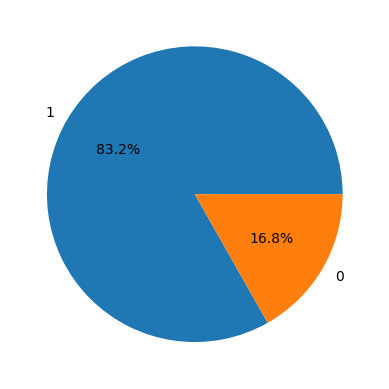

In [12]:
plt.pie(df["target"].value_counts().values,
       labels = df["target"].value_counts().index,
       autopct='%1.1f%%')
plt.show()

In [13]:
## The above graph is very imbalanced, we may need to use randomoverampler to get a more balanced
#view of the dataset

In [14]:
y=df["target"]
X=df["tweet"]

In [15]:
X = pd.get_dummies(X)

In [16]:
X.head()

,0 energy hoes,0 hoes,0 hoes 128588,0 hoes lmfao,0 love hoes,0 rings 0 mvps 0 bitches lol,02 charcoal 7s preowned sole wear scuffs size 105 cherry 12s ds size 115,1 2 3 4 5 i8217m drunk walk let8217s drive got bitches night party don8217t start til drugs arrive loaded,1 2 3 4 many niggers store knooooooow stealing 128514128514128514,1 2 3 4 many niggers store knowwww youre stealing 128514128514128514,...,zebra amongst sheep,zebra tights take home bag mom 128525,zelda bitches lol,zero hoes 128533,zhou mi layin bed sm busted room like gettin song bitch,zimmerman comin yo life bitch,zoneing say im possessed omen keep 300 like omans 300 bitches trojans menace longest,zrgrizz stop paling video games age 40 fucking stop playing like pussies,zuko gets bitches,zulema dont worry bitches act bold somebody back cool tho got anything
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
#convert to integer from boolean
X = X*1

In [18]:
X

,0 energy hoes,0 hoes,0 hoes 128588,0 hoes lmfao,0 love hoes,0 rings 0 mvps 0 bitches lol,02 charcoal 7s preowned sole wear scuffs size 105 cherry 12s ds size 115,1 2 3 4 5 i8217m drunk walk let8217s drive got bitches night party don8217t start til drugs arrive loaded,1 2 3 4 many niggers store knooooooow stealing 128514128514128514,1 2 3 4 many niggers store knowwww youre stealing 128514128514128514,...,zebra amongst sheep,zebra tights take home bag mom 128525,zelda bitches lol,zero hoes 128533,zhou mi layin bed sm busted room like gettin song bitch,zimmerman comin yo life bitch,zoneing say im possessed omen keep 300 like omans 300 bitches trojans menace longest,zrgrizz stop paling video games age 40 fucking stop playing like pussies,zuko gets bitches,zulema dont worry bitches act bold somebody back cool tho got anything
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24779,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state= 1)

In [20]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [21]:
# Instantiate the KNeighborsClassifier model with n_neighbors = 3 
knn = KNeighborsClassifier(n_neighbors=2)

In [22]:
# Train the model using the training data
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

In [23]:
# Create predictions using the testing data
y_pred = knn.predict(X_test_scaled)


In [24]:
# Print the classification report comparing the testing data to the model predictions
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.04      0.90      0.07        41
           1       1.00      0.84      0.91      6155

    accuracy                           0.84      6196
   macro avg       0.52      0.87      0.49      6196
weighted avg       0.99      0.84      0.91      6196



In [24]:
# Define the deep learning model 

nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu', input_dim=24129)) 
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")



Epoch 1/50


581/581 [==============================] - 3s 3ms/step - loss: 0.5124 - accuracy: 0.8071
Epoch 2/50
581/581 [==============================] - 2s 3ms/step - loss: 0.3956 - accuracy: 0.8277
Epoch 3/50
581/581 [==============================] - 2s 3ms/step - loss: 0.2082 - accuracy: 0.9027
Epoch 4/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0798 - accuracy: 0.9695
Epoch 5/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0369 - accuracy: 0.9861
Epoch 6/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0231 - accuracy: 0.9903
Epoch 7/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0175 - accuracy: 0.9924
Epoch 8/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0134 - accuracy: 0.9940
Epoch 9/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0115 - accuracy: 0.9947
Epoch 10/50
581/581 [==============================] - 2s 3ms/step - loss: 0.0089 - accuracy: 0.

In [66]:
!pip install keras-tuner

In [25]:
def create_model(hp):
    nn_model = tf.keras.models.Sequential()
    
    #allow kerastuner to decide the activation funcitons for hidden layers
    activation = hp.Choice('activation', ['relu','tanh','sigmoid'])
    
    #allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
            min_value = 1,
            max_value = 200,
            step =10), activation = activation, input_dim=24129))
    #allow kerastuner to decide number of hidden layers and neurons in the layers
    for i in range(hp.Int('num_layers',1,6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' +str(i),
            min_value = 1,
            max_value = 200,
            step=10), activation = activation))
    #add dropout layer to increase accuracy
    nn_model.add(tf.keras.layers.Dropout(0.25))
    #add activation layer
    nn_model.add(tf.keras.layers.Dense(units=1, activation = "sigmoid"))
    
    #compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [26]:
#import & create kerastuner setup
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective = 'val_accuracy',
    max_epochs = 20,
    hyperband_iterations =2)

In [27]:
#run the kerastuner search for the best parameters
tuner.search(X_train_scaled, y_train, epochs =20, validation_data = (X_test_scaled, y_test))

Trial 60 Complete [00h 02m 21s]
val_accuracy: 0.8373143672943115

Best val_accuracy So Far: 0.8426403999328613
Total elapsed time: 01h 27m 28s


In [41]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 91)                2195830   
                                                                 
 dense_1 (Dense)             (None, 51)                4692      
                                                                 
 dropout (Dropout)           (None, 51)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 52        
                                                                 
Total params: 2200574 (8.39 MB)
Trainable params: 2200574 (8.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [42]:
#evaluate best model against the full test data
model_loss, model_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

194/194 - 1s - loss: 0.6945 - accuracy: 0.8426 - 581ms/epoch - 3ms/step
Loss: 0.6945416927337646, Accuracy: 0.8426403999328613


In [26]:
#run model based on best hyperparameters
# Define the deep learning model 

nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=91, activation ='relu', input_dim=24129)) 
nn_model.add(tf.keras.layers.Dense(units=51, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train, epochs=15)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/15
581/581 [==============================] - 22s 34ms/step - loss: 0.4660 - accuracy: 0.8300
Epoch 2/15
581/581 [==============================] - 23s 40ms/step - loss: 0.0742 - accuracy: 0.9732
Epoch 3/15
581/581 [==============================] - 19s 32ms/step - loss: 0.0028 - accuracy: 0.9992
Epoch 4/15
581/581 [==============================] - 19s 32ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 5/15
581/581 [==============================] - 18s 30ms/step - loss: 0.0013 - accuracy: 0.9995
Epoch 6/15
581/581 [==============================] - 17s 29ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 7/15
581/581 [==============================] - 16s 28ms/step - loss: 0.0011 - accuracy: 0.9995
Epoch 8/15
581/581 [==============================] - 16s 28ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 9/15
581/581 [==============================] - 17s 29ms/step - loss: 0.0012 - accuracy: 0.9993
Epoch 10/15
581/581 [==============================] - 17s 29ms/step - loss: 0.001

In [27]:
#attempt to normalize the data to enhance model performance
from sklearn.preprocessing import normalize

X_train_normalized = normalize(X_train, axis=0)
X_test_normalized = normalize(X_test, axis=0)

In [30]:
#generate a model using normalized data

nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu', input_dim=24129)) 
nn_model.add(tf.keras.layers.Dense(units=16, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_normalized,y_train, epochs=15)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_normalized,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/15
581/581 [==============================] - 6s 8ms/step - loss: 0.4755 - accuracy: 0.8302
Epoch 2/15
581/581 [==============================] - 5s 8ms/step - loss: 0.3688 - accuracy: 0.8305
Epoch 3/15
581/581 [==============================] - 4s 7ms/step - loss: 0.0374 - accuracy: 0.9992
Epoch 4/15
581/581 [==============================] - 4s 8ms/step - loss: 0.0031 - accuracy: 0.9995
Epoch 5/15
581/581 [==============================] - 4s 7ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 6/15
581/581 [==============================] - 4s 7ms/step - loss: 0.0017 - accuracy: 0.9995
Epoch 7/15
581/581 [==============================] - 5s 8ms/step - loss: 0.0016 - accuracy: 0.9993
Epoch 8/15
581/581 [==============================] - 4s 7ms/step - loss: 0.0015 - accuracy: 0.9994
Epoch 9/15
581/581 [==============================] - 5s 8ms/step - loss: 0.0016 - accuracy: 0.9993
Epoch 10/15
581/581 [==============================] - 5s 8ms/step - loss: 0.0013 - accuracy: 0.9995

In [38]:
#use dropout regularization to prevent overfitting
nn_model = tf.keras.models.Sequential()
#input_dim is based on the number of columns in the dataset after removing the y values
nn_model.add(tf.keras.layers.Dense(units=91, activation ='relu', input_dim=24129)) 
nn_model.add(tf.keras.layers.Dense(units=51, activation ='relu'))
nn_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

# Train the model
fit_model = nn_model.fit(X_train_scaled,y_train, epochs=15)

# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/15
581/581 [==============================] - 23s 35ms/step - loss: 0.4658 - accuracy: 0.8272
Epoch 2/15
581/581 [==============================] - 22s 39ms/step - loss: 0.0545 - accuracy: 0.9808
Epoch 3/15
581/581 [==============================] - 22s 37ms/step - loss: 0.0025 - accuracy: 0.9994
Epoch 4/15
581/581 [==============================] - 21s 36ms/step - loss: 0.0016 - accuracy: 0.9994
Epoch 5/15
581/581 [==============================] - 21s 36ms/step - loss: 0.0014 - accuracy: 0.9994
Epoch 6/15
581/581 [==============================] - 18s 31ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 7/15
581/581 [==============================] - 14s 24ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 8/15
581/581 [==============================] - 16s 27ms/step - loss: 0.0012 - accuracy: 0.9994
Epoch 9/15
581/581 [==============================] - 15s 26ms/step - loss: 0.0012 - accuracy: 0.9995
Epoch 10/15
581/581 [==============================] - 14s 24ms/step - loss: 0.001

In [44]:
import pickle

# save the iris classification model as a pickle file
fit_model_pkl_file = "fit_model.pkl"  

with open(fit_model_pkl_file, 'wb') as file:  
    pickle.dump(knn, file)

MemoryError: 

In [ ]:
file = "trump_insult_tweets_2014_to_2021.csv"
ogfile = "labeled_data.csv" 
df = pandas.read_csv(file)
ogdf = pandas.read_csv(ogfile)

In [ ]:
for i in ogdf.index:
    txt = ogdf.loc[i]["tweet"]
    txt=re.sub(r'@[A-Z0-9a-z_:]+','',txt)#replace username-tags
    txt=re.sub(r'[RT]+','',txt)#replace RT-tags
    txt=re.sub('https?://[A-Za-z0-9./]+','',txt)#replace URLs
    ogdf.at[i,"tweet"]=txt

In [ ]:
ogdf.head

In [ ]:
#lower case all words before any preprocessing
ogdf["tweet"] = ogdf["tweet"].str.lower()

#removing punctuation
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '',punctuations_list)
    return text.translate(temp)
ogdf['tweet'] = ogdf['tweet'].apply(lambda x: remove_punctuations(x))
ogdf.tail()

In [ ]:
#remove words that add no value to the tweet
# https://www.geeksforgeeks.org/hate-speech-detection-using-deep-learning/
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    
    imp_words = []
    #store the important words
    for word in str(text).split():
        if word not in stop_words:
            #it's recommended to lemmatize the word as well
            #splitting it into its root which will provide a more accurate measure of which words are hate speech
            lemmatizer =WordNetLemmatizer()
            lemmatizer.lemmatize(word)
            imp_words.append(word)
    output = " ".join(imp_words)
    return output
ogdf['tweet'] = ogdf['tweet'].apply(lambda text: remove_stopwords(text))
ogdf.head()

In [ ]:
ogdf["target"] = ogdf["class"].map({0: 1,
                                 1: 1,
                                 2: 0})
ogdf.head()

In [ ]:
y = ogdf["target"]
X = ogdf["tweet"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train = df['tweet']

In [ ]:
# Load model from disk and use it to make new predictions
loaded_model = pickle.load(open("fit_model.pkl", 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

# Load test dataset
X_train = df['tweet']
pred = fit_model.pkl.predict(X_train)
print(pred)